2.1 **Dependencies**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

2.2 **Dataset**

In [ ]:
with open("data/abc_music.txt", "r", encoding="utf-8") as f:
    songs = f.read().split("\n\n")

print(f"Loaded {len(songs)} songs")

# Inspect one example
example_song = songs[0]
print("\nExample song:\n")
print(example_song)

In [ ]:
# Join into one training string
songs_joined = "\n\n".join(songs)

# Create vocabulary
vocab = sorted(set(songs_joined))
print(f"\nVocabulary size: {len(vocab)}")

There are 83 unique characters in the dataset


2.3 Process the dataset for the learning **task**

In [ ]:
# Character to index mapping
char2idx = {u: i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

print("\nFirst 20 character mappings:")
for char in list(char2idx.keys())[:20]:
    print(f"{repr(char)} → {char2idx[char]}")

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [ ]:
### Vectorize the songs string ###

vocab = sorted(set(songs))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def vectorize_string(string):
    return np.array([char2idx[c] for c in string])

vectorized_songs = vectorize_string(songs)


Create training examples and **targets** **bold text**

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_data, seq_length, batch_size):
    n = len(vectorized_data) - 1
    idx = np.random.choice(n - seq_length, batch_size)

    input_batch = [vectorized_data[i:i+seq_length] for i in idx]
    target_batch = [vectorized_data[i+1:i+seq_length+1] for i in idx]

    x = torch.tensor(input_batch, dtype=torch.long)
    y = torch.tensor(target_batch, dtype=torch.long)

    return x, y


In [ ]:
### Defining the RNN Model ###

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def init_hidden(self, batch_size, device):
        return (
            torch.zeros(1, batch_size, self.hidden_size).to(device),
            torch.zeros(1, batch_size, self.hidden_size).to(device)
        )

    def forward(self, x, state=None):
        x = self.embedding(x)

        if state is None:
            state = self.init_hidden(x.size(0), x.device)

        out, state = self.lstm(x, state)
        out = self.fc(out)

        return out, state


In [ ]:
# Instantiate the model! Build a simple model with default hyperparameters. You
#     will get the chance to change these later.
params = {
    "embedding_dim": 256,
    "hidden_size": 512,
    "batch_size": 32,
    "seq_length": 100,
}

model = LSTMModel(
    len(vocab),
    params["embedding_dim"],
    params["hidden_size"]
).to(device)

print(model)


LSTMModel(
  (embedding): Embedding(83, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=83, bias=True)
)


In [ ]:
x, y = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])
x = x.to(device)
y = y.to(device)

pred, _ = model(x)

print("Input shape:", x.shape)
print("Prediction shape:", pred.shape)


Input shape:       torch.Size([32, 100])  # (batch_size, sequence_length)
Prediction shape:  torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)


In [ ]:
# Sample predictions from the model output (untrained model)
# Apply softmax to convert logits → probabilities
probs = torch.softmax(pred[0], dim=-1)

# Sample one character index per timestep
sampled_indices = torch.multinomial(probs, num_samples=1)

# Remove extra dimension and move to CPU
sampled_indices = sampled_indices.squeeze(-1).cpu().numpy()

# Convert indices back to characters
input_text = "".join(idx2char[x[0].cpu()])
predicted_text = "".join(idx2char[sampled_indices])

print("Input:\n", repr(input_text))
print("\nNext Char Predictions:\n", repr(predicted_text))


array([62, 25, 12, 49,  1, 47, 77, 56, 24, 79, 17, 38, 63, 14, 72, 70, 39,
       29, 32,  7,  5, 31,  2,  0, 31, 61, 13, 44, 37, 54, 43,  5,  4, 79,
       65, 11, 62, 23, 26, 38, 35, 38,  6, 38, 59, 14, 60,  6, 39, 28,  1,
       11, 34,  0, 57, 63, 42, 45, 40, 48, 71,  5, 32, 32, 72,  5, 23, 28,
        1, 57, 30, 22,  7, 78, 49, 77, 24, 71, 33, 53, 48, 17, 13, 82,  8,
       68, 72, 79, 56, 58, 71, 76, 32, 37, 42, 49, 28, 80, 61, 66])

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0].cpu()])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'GE EDE|GAB c2d|eag edB|cAA A2:|!\nB|cBA a3|bag edB|GBd g3|age dBG|!\nABA a3|bag edB|GBd g3|edB A2:|!\n\n'

Next Char Predictions: 
 "g>0X Vva=x5Mh2qoNDG)'F!\nFf1SL^R'#xj/g<AMJM(Md2e(NC /I\nbhQTOWp'GGq'<C bE:)wXv=pH]W51|,mqxacpuGLQXCyfk"


In [ ]:
# Cross entropy loss for next-character prediction
loss_fn = nn.CrossEntropyLoss()

def compute_loss(labels, logits):
    """
    labels: (batch_size, sequence_length)
    logits: (batch_size, sequence_length, vocab_size)

    Returns:
        Scalar cross-entropy loss over the batch
    """

    # Flatten labels to shape: (batch_size * sequence_length,)
    labels = labels.view(-1)

    # Flatten logits to shape: (batch_size * sequence_length, vocab_size)
    logits = logits.view(-1, logits.size(-1))

    # Compute cross-entropy loss
    return loss_fn(logits, labels)


In [ ]:
example_batch_loss = compute_loss(y, pred)

print(f"Prediction shape: {pred.shape}")
print(f"Initial loss (untrained model): {example_batch_loss.item():.4f}")


Prediction shape: torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)
scalar_loss:      4.422314643859863


In [ ]:
# ==============================
# Training Setup
# ==============================

params = {
    "num_training_iterations": 2000,
    "batch_size": 32,
    "seq_length": 100,
    "learning_rate": 3e-4,
    "embedding_dim": 256,
    "hidden_size": 512,
}

vocab_size = len(vocab)

model = LSTMModel(
    vocab_size,
    params["embedding_dim"],
    params["hidden_size"]
).to(device)

optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])

loss_history = []


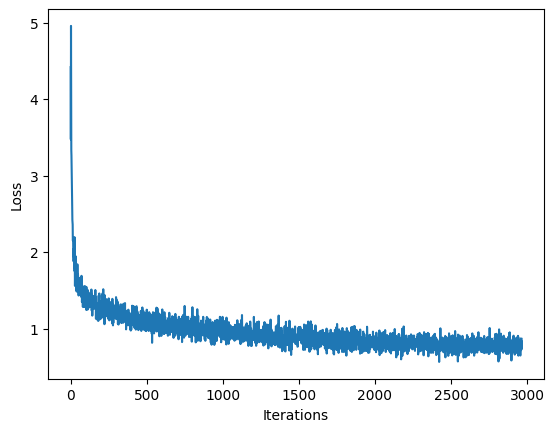

100%|██████████| 3000/3000 [01:46<00:00, 28.28it/s]


True

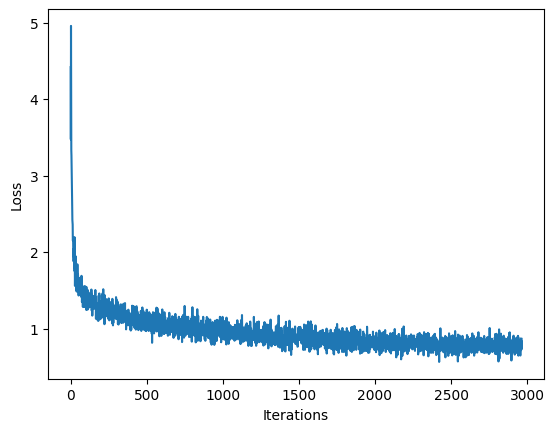

In [ ]:
# ==============================
# Optimizer & Training Setup
# ==============================

model = LSTMModel(
    vocab_size,
    params["embedding_dim"],
    params["hidden_size"]
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=params["learning_rate"]
)

loss_history = []

# ==============================
# Training Loop
# ==============================

for iteration in tqdm(range(params["num_training_iterations"])):

    # Get training batch
    x_batch, y_batch = get_batch(
        vectorized_songs,
        params["seq_length"],
        params["batch_size"]
    )

    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    # Set model to training mode
    model.train()

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    logits, _ = model(x_batch)

    # Compute loss
    loss = compute_loss(y_batch, logits)

    # Backpropagation
    loss.backward()

    # Update parameters
    optimizer.step()

    loss_history.append(loss.item())

    if iteration % 100 == 0:
        print(f"Iteration {iteration} | Loss: {loss.item():.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [ ]:
# ==============================
# Text Generation
# ==============================

def generate_text(model, start_string, generation_length=500):
    model.eval()

    # Convert start string to indices
    input_indices = torch.tensor(
        [char2idx[c] for c in start_string],
        dtype=torch.long
    ).unsqueeze(0).to(device)

    state = None
    generated = start_string

    for _ in range(generation_length):

        # Forward pass
        logits, state = model(input_indices, state)

        # Take only the last timestep prediction
        logits = logits[:, -1, :]

        # Convert logits to probabilities
        probs = torch.softmax(logits, dim=-1)

        # Sample next character
        next_idx = torch.multinomial(probs, num_samples=1)

        # Convert index to character
        next_char = idx2char[next_idx.item()]
        generated += next_char

        # Next input is the predicted character
        input_indices = next_idx.unsqueeze(0)

    return generated


In [ ]:
# ==============================
# Generate Sample Output
# ==============================

generated_text = generate_text(
    model,
    start_string="X:1\n",
    generation_length=800
)

print("\nGenerated Text:\n")
print(generated_text)


100%|██████████| 1000/1000 [00:01<00:00, 956.21it/s]
